In [5]:
# Setup imports
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_probability.python.random as tfr
import matplotlib.pyplot as plt

In [6]:
# Create a function to calculate the dB value of a number, and the number from a dB value
def calcTodB(x):
    return 10*np.log10(x)

def calcFromdB(x):
    return np.power(10, x/10)

In tesfay thesis, he describes the Noise as
$$N_0 = -174 + 10*log10(B) + NF = -114 [dBm]$$
where
- $NF = 6dB$
- $B = 250e3$

as this is in dBm, this is close to the calculations we found of
$N_0 = k*T*B = -149 [dB] = - 119 [dBm] $


In [7]:
# Calculate noise setup
k = 1.38*np.power(10.0,-23) # [J/K]
B = int(250e3) #[Hz]
T = 298.16 #[K]
PN0 = (k * T * B) #[J*Hz] = [W]
#PN0 = -149
#PN0 = calcFromdB(PN0) # [W]
print(f"Noise power: {PN0}, dB: {calcTodB(PN0)}")

Noise power: 1.0286519999999999e-15, dB: -149.87731525180942


As the SNR is defined as
$$
SNR = 10\cdot log_{10}\left(\frac{P_s}{P_N}\right) = 10\cdot log_{10}\left(\frac{P_T \cdot |h_j|^2}{P_N}\right) [dB]
$$
then
$$
\Rightarrow h_j = \pm \sqrt{\frac{10^{\frac{SNR}{10}}\cdot P_N}{P_T}} [W]
$$

We defined the SNRs as being in the set {-4, -6, -8, -10, -12, -14, -16}

Knowing the SNR, we can find the equivalent distance of the transmitter. Tesfay described, in their thesis, the channel coefficient as:
$$
h_i[n]=d_i^{-\frac{\eta}{2}}\Chi_i
$$
where
- $i = transmitter-index$
- $d = distance$
- $\eta = path-loss-exponent$
- $\Chi = Rayleigh-fading$

We assume normalized Rayleigh, that is
$ \sigma = \frac{1}{\sqrt{2}}$. Why? IDK

Tesfay described $\eta$ as being 3.5

In [285]:
def getRayleighSamples(n:int, v:bool = False):
    real = tf.random.normal([n], mean=0.0, stddev=1.0, dtype=tf.float32)
    imag = tf.random.normal([n], mean=0.0, stddev=1.0, dtype=tf.float32)
    ray = tf.abs((1/tf.sqrt(tf.constant(2,dtype=tf.complex64)))*tf.complex(real, imag))
    return ray

def getPSfromSNR(SNR, Pt, v:bool = False):
    # To estimate the distance accurately, we pull alot of Rayleig samples and average them
    SNR_lin = calcFromdB(SNR)
    hj = np.sqrt((SNR_lin * PN0)/(Pt))
    Ps = np.power(hj,2.0) * Pt
    if v:
        print(f"Length of Ps: {len(Ps)}")
        print(f"Ps spans {np.min(Ps)} and {np.max(Ps)}")
    return Ps

def calcDfromPs(Ps, eta, tp, v:bool = False):
    d = np.power(Ps/(tp), -1/eta)
    if v:
        print(f"Length of d: {len(d)}")
        print(f"D spans {np.min(d)} and {np.max(d)}")
    return d

def calcPSfromD(d, eta, ray_scale:bool, tp, v:bool = False):
    ray = getRayleighSamples(len(d), v = v)
    dist_loss = np.power(d, -eta)
    Ps = dist_loss * tp
    if ray_scale:
        Ps = Ps * ray**2
    else:
        Ps = Ps * np.mean(ray**2)
    print(f"mean ray: {np.mean(ray**2)}")
    if v:
        print(f"Length of Ps: {len(Ps)}")
        print(f"Ps spans {np.min(Ps)} and {np.max(Ps)}")
    return Ps

# Get SNRS in lin scale
SNR = np.linspace(-4, -16, 7) #[dB]
# Calculate Transmit Power - According to PhD then 14 dBm is the transmit power
tp = calcFromdB(-62) # [W]
eta = 3.5
Ps = getPSfromSNR(SNR,tp, v = True)
d = calcDfromPs(Ps, eta, tp, v = True)
for i, snr in enumerate(SNR):
    print(f"SNR: {snr}, Ps: {calcTodB(Ps[i])}, SNR: {calcTodB(Ps[i]/PN0):.2f} distance: {d[i]}")

ray_test = getRayleighSamples(int(1e5), v = True)
print(np.mean(ray_test**2))

Length of Ps: 7
Ps spans 2.5838570015451924e-17 and 4.09513737204196e-16
Length of d: 7
D spans 421.7607394970121 and 928.8023229484373
SNR: -4.0, Ps: -153.87731525180942, SNR: -4.00 distance: 421.7607394970121
SNR: -6.0, Ps: -155.87731525180942, SNR: -6.00 distance: 481.0708113722561
SNR: -8.0, Ps: -157.87731525180942, SNR: -8.00 distance: 548.7213575885728
SNR: -10.0, Ps: -159.87731525180942, SNR: -10.00 distance: 625.8852567150592
SNR: -12.0, Ps: -161.87731525180942, SNR: -12.00 distance: 713.9003232802787
SNR: -14.0, Ps: -163.87731525180942, SNR: -14.00 distance: 814.2925018790012
SNR: -16.0, Ps: -165.87731525180942, SNR: -16.00 distance: 928.8023229484373
0.9938877


To calculate other transmitters strength, we pull them from a uniform distribution, calculate path loss and add a rayleigh.

To get the distribution, we make a plot for each of distance

If we use the set $r_{min} = 200, r_{max} = 1000$ as described in Tesfay, then we get the following

Length of d: 7
D spans 249.16940864198153 and 548.7213575885728
mean ray: 0.9635809063911438
PU min: -165.87731525180942, max: -153.87731525180942, mean: -159.87731525180945
PI min: -175.1611181424771, max: -150.69716799071645, mean: -166.0736471005863


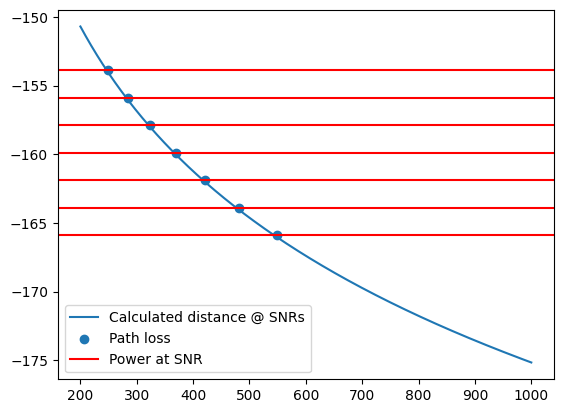

In [286]:
def plot(d_in, Ps_in, eta, transmit_power, SNR, rmin, rmax, ray_scale:bool = False):
    distance = np.linspace(rmin, rmax, 1000)
    Ps = calcPSfromD(distance, eta, ray_scale, transmit_power)
    plt.plot(distance, calcTodB(Ps))
    plt.scatter(d_in, calcTodB(Ps_in))
    for i in range(len(SNR)):
        plt.axhline(calcTodB(Ps_in[i]), color='r')
    print(f"PU min: {np.min(calcTodB(Ps_in))}, max: {np.max(calcTodB(Ps_in))}, mean: {np.mean(calcTodB(Ps_in))}")
    print(f"PI min: {np.min(calcTodB(Ps))}, max: {np.max(calcTodB(Ps))}, mean: {np.mean(calcTodB(Ps))}")

    plt.legend(["Calculated distance @ SNRs","Path loss", "Power at SNR"])
    plt.show()

tp = calcFromdB(-70) # [W]
d = calcDfromPs(Ps, eta, tp, v = True)
plot(d, Ps, eta, tp, SNR, 200, 1000, False)

mean ray: 0.9513696432113647
xxxxxxx

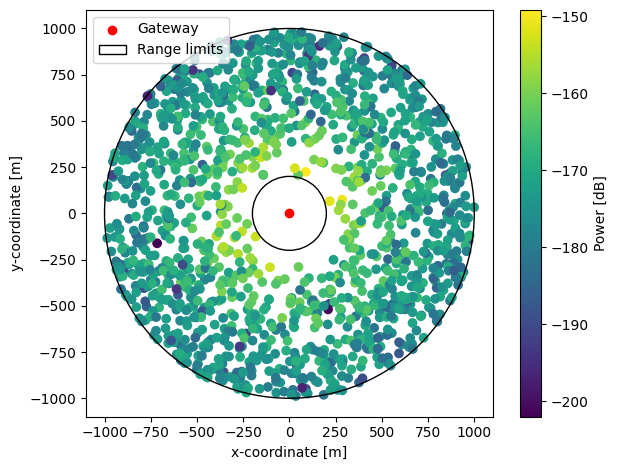

In [406]:
N = int(1.5e3)
offset = 0
R = np.sqrt(np.random.uniform(size = N))*800 + 200
theta = np.random.uniform(size = N)*2*np.pi
x = R*np.cos(theta)
y = R*np.sin(theta)
d_i = np.sqrt(x**2 + y**2)
Pi = calcPSfromD(d_i, eta, True, tp)
plt.scatter(offset, offset, c = 'r', label="Gateway")
plt.scatter(x + offset, y + offset, c = calcTodB(Pi),cmap='viridis')
for i in range(len(SNR)):
    #plt.gca().add_patch(plt.Circle((1000,1000), d[i], edgecolor='r', facecolor='none'))
    print("x", end="")
plt.gca().add_patch(plt.Circle((offset,offset), 1000, edgecolor='black', facecolor='none', label="Range limits"))
plt.gca().add_patch(plt.Circle((offset,offset), 200, edgecolor='black', facecolor='none'))
plt.colorbar(label="Power [dB]")
plt.xlabel("x-coordinate [m]")
plt.ylabel("y-coordinate [m]")
plt.gca().set_aspect('equal')
plt.legend()
plt.rcParams["legend.loc"] = 'upper left'
#plt.show()

plt.tight_layout()
plt.savefig(
    f"./distribution_of_transmitters.pdf",
    format = "pdf",
    bbox_inches = "tight"
)